<!--HEADER-->
*Documentation for the EpiSiming epidemic simulation package*

<!--BADGES-->
<a href="https://colab.research.google.com/github/episiming/epsiming/blob/master/notebooks/01.02-Atributos_de_localizacao.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a><a href="https://mybinder.org/v2/gh/episiming/episiming/master?filepath=notebooks/01.02-Atributos_de_localizacao.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open in Binder"></a><a href="https://nbviewer.jupyter.org/github/episiming/episiming/blob/master/notebooks/01.02-Atributos_de_localizacao.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://raw.githubusercontent.com/episiming/episiming/master/notebooks/01.02-Atributos_de_localizacao.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/download-notebook-9cf" alt="Download Notebook" title="Download Notebook"></a>&nbsp;

<!--NAVIGATOR-->
[<- Descrição dos atributos dos indivíduos e das residências](01.01-Atributos_dos_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Construção dos atributos de idade e infectividade potencial relativa dos indivíduos ->](01.03-Atributos_de_idade_e_infectividade.ipynb)

---


# A matriz populacional do LandScan

- Os atributos de localização são baseados em uma divisão da região em **blocos** e **subblocos** e nos dados populacionais de número de habitantes por bloco e subbloco.

- Essa informação populacional é obtida do [LandScan](https://landscan.ornl.gov).

- Esses dados são cruzados com divisão administrativa do Rio de Janeiro em bairros.

- No entanto, há certas discrepâncias entre os dados que buscamos reduzir aqui, antes de gerar os atributos de localização da população e de suas residências.

In [3]:
import datetime

import os, sys

import yaml

import math

import random

import numpy as np
from scipy.interpolate import interp2d

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [5]:
sns.set_style("darkgrid")

In [6]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 17/Jul/2020


## Ideia geral

- Essa distribuição populacional é feita a partir de dados obtidos do [LandScan](https://landscan.ornl.gov), cruzados com a localização dos bairros.

- Os dados do [LandScan](https://landscan.ornl.gov) são disponibilizados por **blocos** de *aproximadamente* $1 \;\textrm{km}^2$, com o **número de habitantes em cada bloco**.

- A localização dos bairros é transformada em um reticulado em subblocos de aproximadamente 100 x 100 metros quadrados, com o **bairro associado a cada subbloco**.

- Neste cruzamento entre os dados do LandScan e os dados de bairro, um reticulado mais fino é criado, com o **número de habitantes em cada subbloco**.

- Discrepâncias são corrigidas por conta de nem todos os blocos povoados segundo o LandScan estarem representados por um bairro, ou seja, podendo estar localizadas no mar, por exemplo.

### Resolução do LandScan

- Os dados do [LandScan](https://landscan.ornl.gov) são, na verdade, do número de habitantes por bloco de 30" x 30" (onde " indica segundos de arco).

- A metragem exata dos blocos depende da latitude. As coordenadas geográficas do (centro do) Rio de Janeiro são latitude: 22° 54' 30'' Sul e longitude: 43° 11' 47'' Oeste.

- No equador, um minuto de arco corresponde a uma milha náutica, i.e. 1852 metros.

- Corrigindo para latitude de 23 graus e dividindo por 2 para termos 30", obtemos

    $$ \text{30" de arco longitudinal no Rio de Janeiro} \approx \frac{\cos\left(\frac{180\pi}{23}\right) \times 1852}{2} \approx 852.39 \;\text{metros}.
    $$

- Já a distância latitudinal não é muito afetada pela latitude e temos

    $$ \text{30" de arco latitudinal no Rio de Janeiro} \approx \text{30" de arco latitudinal na linha do equador} = \frac{1852}{2} \;\text{metros} = 926 \;\text{metros}.
    $$
    
- Cada segundo de arco nos dá uma resolução, no Rio de Janeiro, de $28.41 \times 30.87$ metros quadrados.

- O reticulado mais fino nos dá blocos 3" x 3", ou seja, de aproximadamente $85.23 \times 92.61$ metros quadrados.

### Matriz populacional obtida do Landscan

- Do [LandScan](https://landscan.ornl.gov), obtemos uma matriz com, entre outras coisas, informações da população em cada bloco de 30" x 30".

- No caso do Rio de Janeiro, obtemos um matrix 39 x 83.

- A matriz foi processada no [QGIS](https://qgis.org/en/site/) e uma **matriz populacional**, em formato `numpy.ndarray`, foi obtida, apenas com os dados de população por bloco.

- Alguns blocos contém o valor -1, indicando falta de informação.

- Outros contém o valor 0, indicando que não há habitantes no bloco, o que pode indicar um bloco no mar, na baía de Guanabara ou em algum área terrestre desocupada, como alguma área de reserva ambiental.

- Abaixo, carregamos a matriz na memória, substituímos o valor -1 por 0 e obtemos algumas informações.

In [7]:
landscan_rio = np.load(os.path.join('..', 'input', 'dados_rio',
                                    'landscan_rio_paqueta.npy')).astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape
landscan_rio_xextent = landscan_rio_xdim*landscan_rio_xscale
landscan_rio_yextent = landscan_rio_ydim*landscan_rio_yscale

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print('Região representada pelo LandScan: ',
      f'{landscan_rio_xextent:.3f} x {landscan_rio_yextent:.3f} km^2')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {len(landscan_rio[landscan_rio>0])}')
print(f'População: {landscan_rio.sum()}')

Dimensão da matriz de blocos: (39, 83)
Região representada pelo LandScan:  70.748 x 36.114 km^2
Total de blocos: 3237
Total de blocos habitados: 1473
População: 6860819


### Visualização em escala logarítmica

- Usamos escala logarítmica para visualizar melhor a variação na população:

$$ \ln( 1 + \textrm{população})
$$

- Ajustamos, ainda, as escalas dos eixos de acordo com a resolução do [LandScan](https://landscan.ornl.gov) para o Rio de Janeiro

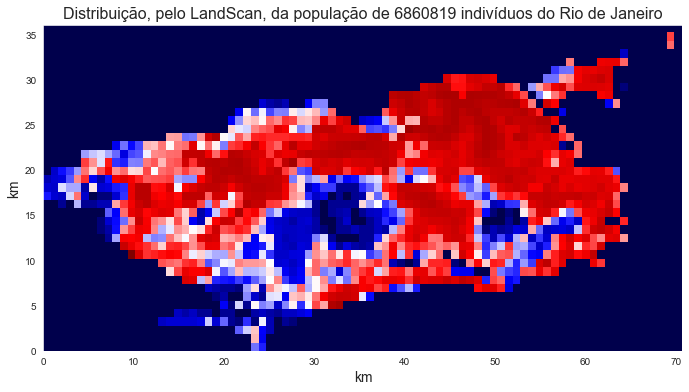

In [8]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Distribuição, pelo LandScan, da população de {int(landscan_rio.sum())} indivíduos do Rio de Janeiro',
          fontsize=16)
plt.show()

### Sobre a resolução da malha

- Observe que a malha está visivelmente grosseira.

- Se usarmos essa resolução para posicionar os indivíduos, corremos o risco de distribuir os indivíduos em locais inabitáveis, como o mar e a baía.

- Além disso, com essa resolução, a associação com os bairros gera inconsistências.

- Para resolver isso, fazemos o seguinte:
    
    - carregamos uma matriz de bairros com uma resolução melhor; e
    
    - interpolamos os dados da matriz populacional para a resolução mais fina da matriz de bairros.
    
- Naturalmente, a interpolação deve preservar o total de habitantes de cada bloco da matriz populacional.

### Bairros

- A matriz de bairros é obtida de a partir de dados da prefeitura [link?]

- Um arquivo do tipo [shapefile](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/what-is-a-shapefile.htm) é obtido, com a delimitação de cada bairro.

- No [QGIS](https://qgis.org/en/site/), após definirmos uma resolução espacial, exportamos os dados para uma **matriz de bairros**, associando cada bloco a um bairro.

- Aqui, definimos uma resolução 100 vezes maior do que a obtida do [LandScan](https://landscan.ornl.gov). Mais precisamente, 10 vezes mais fina em cada direção.

- Obtemos, assim, uma matriz 390 x 830.

- Cada bloco da matriz de bairros cobre uma área de 3" x 3", ou seja, aproximadamente 85,2 x 92,6 metros quadrados.

- Cada elemento da matriz é um número inteiro; cada número inteiro representando um bairro.

- São 163 bairros.

### Subblocos com os bairros

In [9]:
matriz_bairros_MRJ_fina = np.load(
        os.path.join('..', 'input', 'dados_rio','geoloc_Bairros_MRJ_fino.npy')
    ).astype(int)

In [10]:
print(f'Dimensões da matriz fina de bairros: {matriz_bairros_MRJ_fina.shape}')
print(f'Número de bairros: {matriz_bairros_MRJ_fina.max()}')

Dimensões da matriz fina de bairros: (390, 830)
Número de bairros: 163


In [11]:
tx_refinamento_x = matriz_bairros_MRJ_fina.shape[1] // landscan_rio.shape[1]
tx_refinamento_y = matriz_bairros_MRJ_fina.shape[0] // landscan_rio.shape[0]
micro_escala_x = landscan_rio_xscale / tx_refinamento_x / 10
micro_escala_y = landscan_rio_xscale / tx_refinamento_y / 10

### Lista de bairros

In [12]:
with open(os.path.join('..', 'input', 'dados_rio','bairros.yml')) as f:
    bairros = yaml.load(f, Loader=yaml.FullLoader)
    id_bairros = bairros['id_bairros']
    bairros_id = bairros['bairros_id']
    del(bairros)

print('Índice do bairro do FLAMENGO:', bairros_id['Flamengo'.upper()])
print('Bairro de índice 33:', id_bairros[33])

Índice do bairro do FLAMENGO: 15
Bairro de índice 33: TIJUCA


### Visualizando a divisão administrativa do Rio de Janeiro

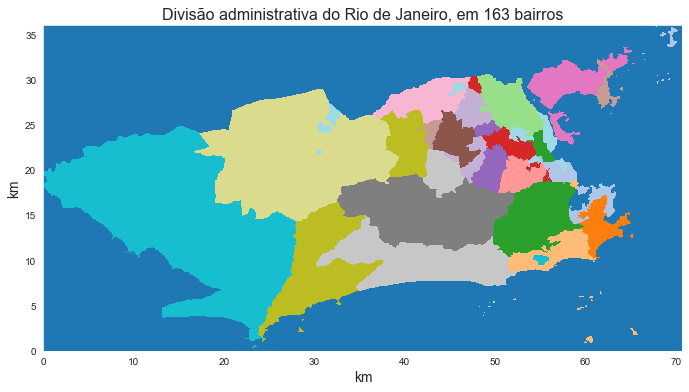

In [13]:
plt.figure(figsize=(12,6))
plt.imshow(matriz_bairros_MRJ_fina, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro, em {matriz_bairros_MRJ_fina.max()} bairros',
          fontsize=16)
plt.show()

## Superposição dos bairros com o LandScan

In [14]:
landscan_rio_contraste = np.minimum(landscan_rio, 1)
matriz_bairros_fina_constraste = np.minimum(matriz_bairros_MRJ_fina, 1)

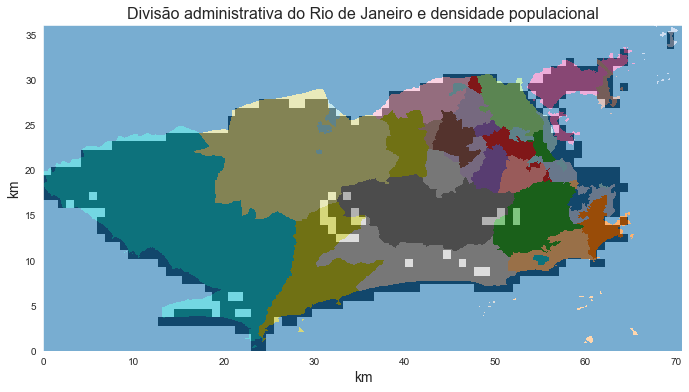

In [15]:
plt.figure(figsize=(12,6))
plt.imshow(matriz_bairros_MRJ_fina, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(landscan_rio_contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional',
          fontsize=16)
plt.show()

### Diferença entre os dados de bairro e os do LandScan

- Observe, na imagem acima, um aparente deslocamento entre as duas imagens, indicando a possibilidade de haver, ao sul da cidade, blocos do LandScan que não tenham associação com bairros.

### Deslocando a matriz de bairros

- Para corrigir essa visível diferença, fazemos um deslocamento norte-sul da matriz de bairros.

- Como o deslocamento que funciona melhor é de uma fração de bloco, fazemos esse deslocamento na matriz fina de bairros.

### Implementando o deslocamento

In [16]:
def desloca_matriz(matriz, deslocamento):
    if deslocamento == 0:
        matriz_desloc = matriz
    else:        
        matriz_desloc = np.vstack(
            [np.zeros([deslocamento, matriz.shape[1]]),
             matriz[:-deslocamento, :]
            ]
        ).astype(int)
    return matriz_desloc

In [17]:
matriz_bairros_MRJ_fina_desloc \
    = desloca_matriz(matriz_bairros_MRJ_fina, 5)

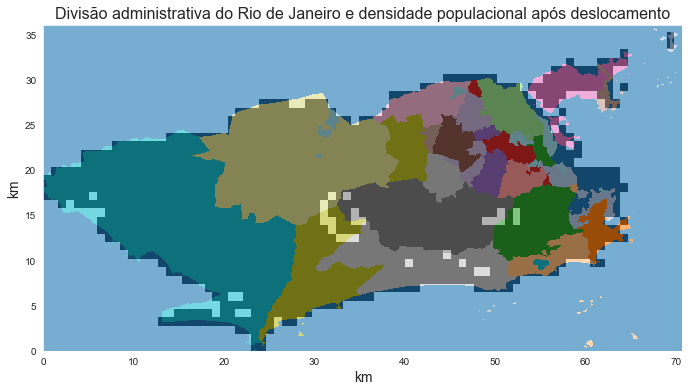

In [18]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0, landscan_rio_yextent])
plt.imshow(matriz_bairros_MRJ_fina_desloc, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.6)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional após deslocamento',
          fontsize=16)
plt.show()

## Refinamento da malha populacional

- Vamos interpolar os dados, mas devemos tomar cuidado em preservar o total da população de cada bloco.

- Uma solução para essa interpolação é a seguinte:

    - interpretar o número de habitantes por bloco como uma distribuição de probabilidade;
    
    - interpolar essa distribuição de maneira linear por partes;
    
    - distribuir as residências e os habitantes de cada bloco pelos subblocos, usando a distribuição interpolada como pesos.
   
- Caso haja uma sobra, por conta da possibilidade de nem todos os blocos do LandScan estarem associados a um bairro:

    - essa sobra também é distribuída aleatoriamente, desta vez em toda a região, usando a distribuição interpolada como pesos.
    
    - essa distribuição é utilizada para se definir uma matriz "corrigida" do LandScan, para que todos os blocos habitados estejam associados a algum bairro.

In [43]:
def refine_matrix(matrix, finer_matrix):
    '''
    Generates an interpolated matrix based on "finer" mask matrix.
    
    It uses linear interpolation to obtain a matrix with the same
    dimensions of the mask matrix and with zeros where the mask
    matrix vanishes.  
    '''
    
    if (finer_matrix.shape[0] % matrix.shape[0] 
        + finer_matrix.shape[1] % matrix.shape[1] > 0):
        raise AttributeError(
            'Each dimension of the "finer_matrix" has to be an integer ' \
            + 'multiple of those of the given "matrix".')
                
    tx_refinamento_x = finer_matrix.shape[1] // matrix.shape[1]
    tx_refinamento_y = finer_matrix.shape[0] // matrix.shape[0]    
    
    matriz_fina = np.zeros_like(finer_matrix)
    matriz_corrigida = np.copy(matrix)
    id_nao_alocados = list() 

    xs = list(range(matrix.shape[1]))
    ys = list(range(matrix.shape[0]))

    xs_fino = np.arange(0, matrix.shape[1], 1/tx_refinamento_x)
    ys_fino = np.arange(0, matrix.shape[0], 1/tx_refinamento_y)

    f = interp2d(xs, ys, matrix, kind='linear')
    matriz_interp \
        = f(xs_fino, ys_fino)*(np.maximum(np.minimum(finer_matrix,1),0))

    for j in xs:
        for i in ys:
            if matrix[i,j]:
                matriz_interp_local \
                    = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x]
                if matriz_interp_local.sum() > 0:
                    distrib = np.floor(matrix[i,j]*matriz_interp_local
                                           / matriz_interp_local.sum()
                                      ).astype('int')
                    sobra = matrix[i,j] - distrib.sum()
                    sobra_posicionamento \
                        = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                           sobra,
                                           replace=True,
                                           p=(matriz_interp_local
                                              /matriz_interp_local.sum()
                                             ).flatten()
                                          )
                    for loc in sobra_posicionamento:
                        distrib[loc // tx_refinamento_x,
                                loc % tx_refinamento_x] += 1
                    matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x] \
                        = distrib
                else:
                    id_nao_alocados.append([i,j])
                    matriz_corrigida[i,j] = 0
                        
    total_nao_alocados = sum([matrix[ij[0], ij[1]] for ij in id_nao_alocados])
    if total_nao_alocados > 0:
        distrib_nao_alocados \
            = np.random.choice(finer_matrix.shape[0]*finer_matrix.shape[1],
                               total_nao_alocados,
                               replace=True,
                               p=(matriz_interp/matriz_interp.sum()).flatten()
                              )

        for na in distrib_nao_alocados:
            ii = na // finer_matrix.shape[1]
            jj = na % finer_matrix.shape[1]
            i = ii // tx_refinamento_x
            j = jj // tx_refinamento_y
            matriz_fina[ii, jj] += 1
            matriz_corrigida[i, j] += 1
    
    return matriz_fina, matriz_corrigida, total_nao_alocados

In [44]:
for deslocamento in range(10):
    matriz_bairros_MRJ_fina_desloc \
        = desloca_matriz(matriz_bairros_MRJ_fina, deslocamento)
    landscan_rio_fino, landscan_rio_corrigido, total_nao_alocados \
        = refine_matrix(landscan_rio, matriz_bairros_MRJ_fina_desloc)
    print(f'\nDeslocamento = {deslocamento}:')
    print(f'População não alocada: {total_nao_alocados}')


Deslocamento = 0:
População não alocada: 34156

Deslocamento = 1:
População não alocada: 30699

Deslocamento = 2:
População não alocada: 8195

Deslocamento = 3:
População não alocada: 8052

Deslocamento = 4:
População não alocada: 16

Deslocamento = 5:
População não alocada: 1

Deslocamento = 6:
População não alocada: 8921

Deslocamento = 7:
População não alocada: 35159

Deslocamento = 8:
População não alocada: 43543

Deslocamento = 9:
População não alocada: 57892


### Análise do resultado

- Vê-se que o deslocamento com menor população não alocada é `deslocamento=5`.

- Usamos esse deslocamento de agora em diante.

- E gravamos em disco a matrix corrigida.

In [46]:
matriz_bairros_MRJ_fina_desloc  = desloca_matriz(matriz_bairros_MRJ_fina, 5)
landscan_rio_fino, landscan_rio_corrigido, total_nao_alocados \
    = refine_matrix(landscan_rio, matriz_bairros_MRJ_fina_desloc)
print(f'População não alocada: {total_nao_alocados}')

População não alocada: 1


In [47]:
print('População total na matriz populacional original:', landscan_rio.sum())
print('População total na matriz populacional corrigida:', landscan_rio_corrigido.sum())
print('População total na matriz refinada:', landscan_rio_fino.sum())

População total na matriz populacional original: 6860819
População total na matriz populacional corrigida: 6860819
População total na matriz refinada: 6860819


In [48]:
np.save(os.path.join('..', 'input', 'dados_rio','landscan_rio_corrigido.npy'), 
        landscan_rio_corrigido)

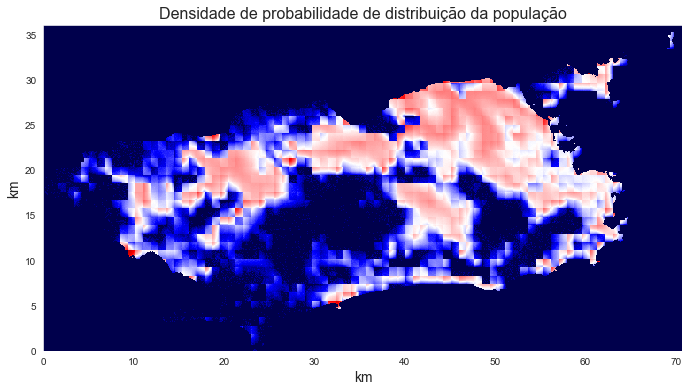

In [35]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio_fino), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

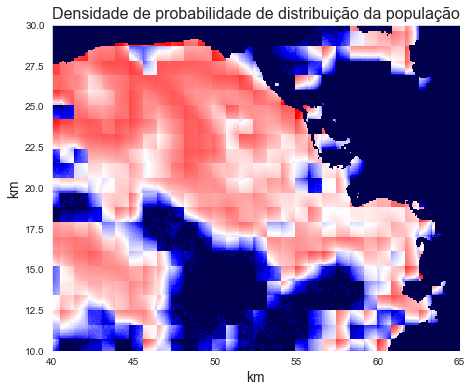

In [36]:
plt.figure(figsize=(12,6))
fino_ydim, fino_xdim = landscan_rio_fino.shape
plt.imshow(np.log(1 + landscan_rio_fino[1 * fino_ydim // 7:5 * fino_ydim // 7,
                                        8 * fino_xdim // 14: 13 * fino_xdim // 14]),
           cmap='seismic', interpolation='none',
           extent=[8 *landscan_rio_xextent // 14, 13 *landscan_rio_xextent // 14,
                   2 * landscan_rio_yextent // 7, 6 * landscan_rio_yextent // 7])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

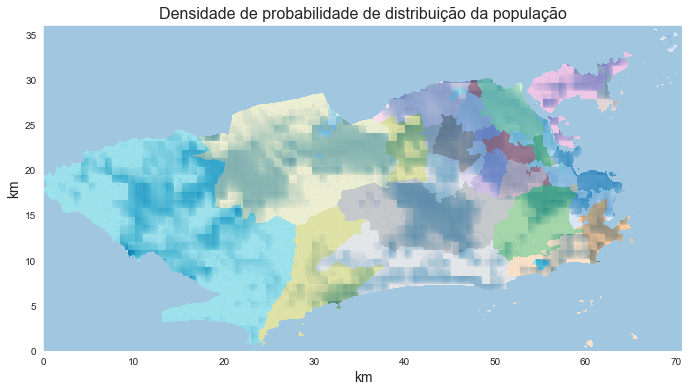

In [37]:
plt.figure(figsize=(12,6))
plt.imshow(matriz_bairros_MRJ_fina_desloc, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=1)
plt.imshow(np.log(1 + landscan_rio_fino), cmap='Blues', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.6)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

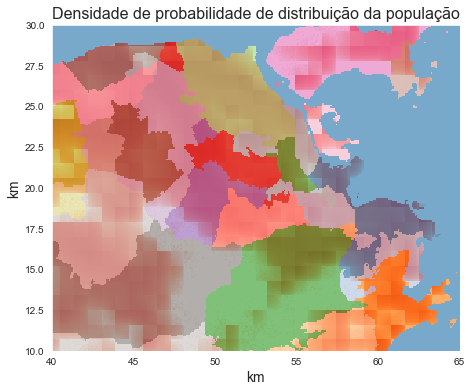

In [38]:
plt.figure(figsize=(12,6))
fino_ydim, fino_xdim = landscan_rio_fino.shape
plt.imshow(matriz_bairros_MRJ_fina_desloc[1 * fino_ydim // 7:5 * fino_ydim // 7,
                                        8 * fino_xdim // 14: 13 * fino_xdim // 14],
           cmap='tab20', interpolation='none',
           extent=[8 *landscan_rio_xextent // 14, 13 *landscan_rio_xextent // 14,
                   2 * landscan_rio_yextent // 7, 6 * landscan_rio_yextent // 7],
           alpha=1)
plt.imshow(np.log(1 + landscan_rio_fino[1 * fino_ydim // 7:5 * fino_ydim // 7,
                                        8 * fino_xdim // 14: 13 * fino_xdim // 14]),
           cmap='Reds', interpolation='none',
           extent=[8 *landscan_rio_xextent // 14, 13 *landscan_rio_xextent // 14,
                   2 * landscan_rio_yextent // 7, 6 * landscan_rio_yextent // 7],
           alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

<!--NAVIGATOR-->

---
[<- Descrição dos atributos dos indivíduos e das residências](01.01-Atributos_dos_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Construção dos atributos de idade e infectividade potencial relativa dos indivíduos ->](01.03-Atributos_de_idade_e_infectividade.ipynb)